# Sounds

A demo of sound synthesis, done the most painstaking way possible.

This was also an excuse for me to try [Julia](https://julialang.org), so please try not to judge my non-idiomatic code.

### Import dependencies

In [12]:
using Plots
using DSP

### Constants

In [13]:
params = Dict()
params["sampling frequency"] = 41000

41000

## Step 0: Making a kickdrum

This seems like as easy an instrument as any to emulate:
- A real one can only play one note
- Its sound is dominated by a single frequency

### Just a sine wave
this is a sine wave. `t` is in seconds, and `a` is audio magnitude.

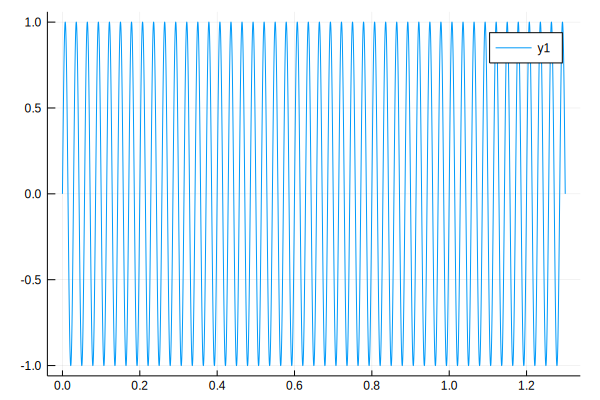

In [14]:
kick = Dict()
kick["base frequency"] = 35
kick["note length"] = 0.65

kick["time"] = collect(0:(1 / params["sampling frequency"]):(kick["note length"] * 2))
sine_amplitude = [sin(e * kick["base frequency"] * 2 * pi) for e in kick["time"]]
plot(kick["time"], sine_amplitude)

## Adding an envelope

First we need to make one!\

### A generic envelope function

In [15]:
function envelope(t, l; attack=0.0, decay=0.0, sustain=1.0, release=0.0)
    if t < attack
        return t / attack
    elseif t < (attack + decay)
        progress_through_decay = (t - attack) / decay
        distance_to_go = 1 - sustain
        return 1 - distance_to_go * progress_through_decay
    elseif t < l
        return sustain
    elseif t < (l + release)
        progress_through_release = (t - l) / release
        return sustain * (1 - progress_through_release)
    else
        return 0.0
    end
end

envelope (generic function with 1 method)

Let's kick the tires on this.

### Amplitude envelope

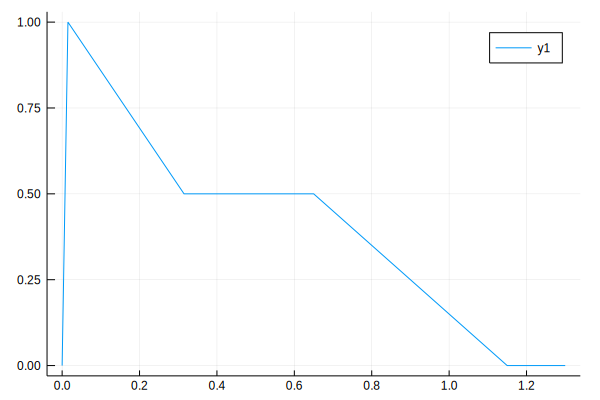

In [16]:
kick["attack"] = 0.015
kick["decay"] = 0.3
kick["sustain"] = 0.5
kick["release"] = 0.5

kick_amp_env = [envelope(time, kick["note length"], attack=kick["attack"], decay=kick["decay"],
        sustain=kick["sustain"], release=kick["release"]) for time in kick["time"]]
plot(kick["time"], kick_amp_env)

Okay, that looks good. now let's:

### Apply it to the sine wave

All we have to do is multiply them together elementwise.

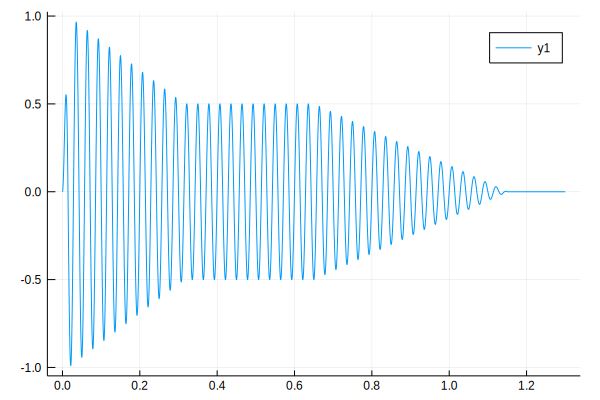

In [17]:
plot(kick["time"], sine_amplitude .* kick_amp_env)

Okay, great so far.

Now we need to do something weird: the truth is, it won't sound very good the way it is now. It's at a constant frequency, so it lacks punch and dimension.

We can fix this by modulating the frequency. This will help it sound more like a real kickdrum.

## Pitch Envelopes

For our purposes, we won't worry about phase. Just ignore it.

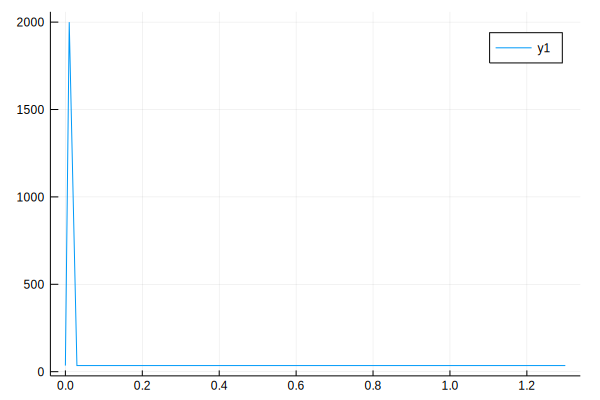

In [18]:
kick["peak frequency"] = 2000
kick["freq attack"] = 0.01
kick["freq decay"] = 0.02

freq_span = kick["peak frequency"] - kick["base frequency"]
kick_freq_env = [envelope(time, kick["note length"], attack=kick["freq attack"], decay=kick["freq decay"], sustain=0.0) * 
    freq_span + kick["base frequency"] for time in kick["time"]]

plot(kick["time"], kick_freq_env)

Now we can generate a frequency-modulated sine wave.

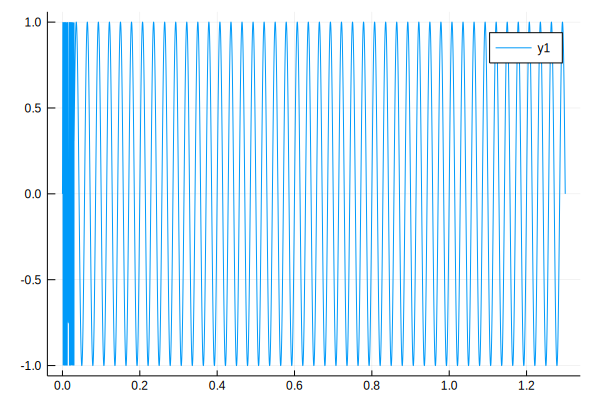

In [19]:
fm_amplitude = [sin(e * k * 2 * pi) for (e, k) in zip(kick["time"], kick_freq_env)]
plot(kick["time"], fm_amplitude)

And (finally) we can combine these concepts into an emulation that almost sounds okay.

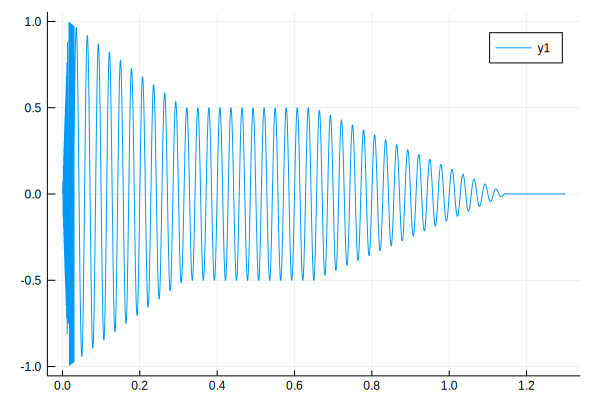

In [20]:
kick["amplitude"] = fm_amplitude .* kick_amp_env

plot(kick["time"], kick["amplitude"])

To be completely honest, it probably sounds terrible. We could remedy that by using non-linear envelopes, but that would add unnecessary complexity.

On to the next instrument...

## Step 1: Making a snare drum

A snare drum is more complicated than a kickdrum, but it basically can be emulated in two parts:
- A frequency-modulated sine wave with an amplitude envelope (like a higher-pitched kickdrum)
- Some Gaussian ("white") noise with filter and amplitude envelopes

These parts can be added together to make a semi-convincing snare. Let's see if we can do it.

### The tonal component of a snare drum

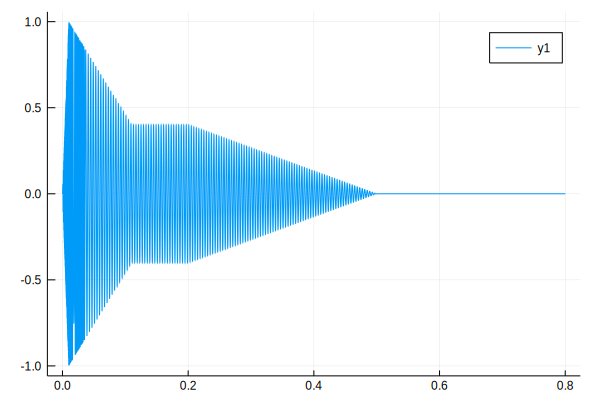

In [21]:
snare = Dict()

# frequency params
snare["peak frequency"] = 5000
snare["base frequency"] = 250
snare["freq attack"] = 0.01
snare["freq decay"] = 0.025

# amplitude params
snare["note length"] = 0.2
snare["attack"] = 0.01
snare["decay"] = 0.1
snare["sustain"] = 0.4
snare["release"] = 0.3

# make time vector
snare["time"] = collect(0:(1 / params["sampling frequency"]):(snare["note length"] * 4))

# make frequency envelope
freq_span = snare["peak frequency"] - snare["base frequency"]
snare_freq_env = [envelope(time, snare["note length"], attack=snare["freq attack"], decay=snare["freq decay"],
        sustain=0.0) * freq_span + snare["base frequency"] for time in snare["time"]]

# make sine sweep
fm_amplitude = [sin(e * k * 2 * pi) for (e, k) in zip(snare["time"], snare_freq_env)]

# make amp envelope
snare_amp_env = [envelope(time, snare["note length"], attack=snare["attack"], decay=snare["decay"],
        sustain=snare["sustain"], release=snare["release"]) for time in snare["time"]]

# combine them and store their product
snare["sine_amplitude"] = fm_amplitude .* snare_amp_env

# plot the sine sweep
plot(snare["time"], snare["sine_amplitude"])

That looks pretty reasonable.

### The atonal component of a snare drum

This is where things start to get tricky. Let's see how far we can get without introducing any new concepts.

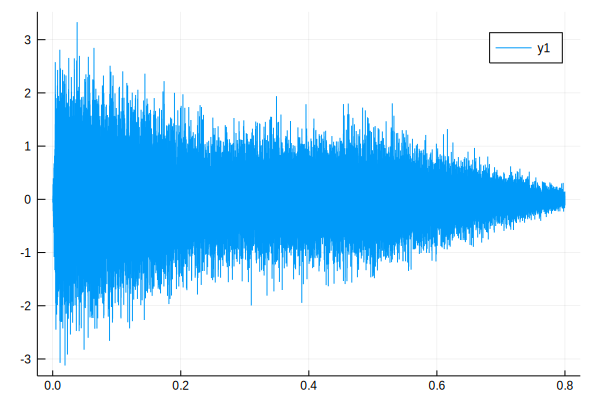

In [22]:
# just the noise amplitude params
snare["noise length"] = 0.5
snare["noise attack"] = 0.005
snare["noise decay"] = 0.25
snare["noise sustain"] = 0.5
snare["noise release"] = 0.35

# make an amp envelope for the noise
snare_amp_env = [envelope(time, snare["noise length"], attack=snare["noise attack"], decay=snare["noise decay"],
        sustain=snare["noise sustain"], release=snare["noise release"]) for time in snare["time"]]

# make some noise and apply the envelope
snare_noise_raw = randn(size(snare["time"]))
snare_noise_amped = snare_noise_raw .* snare_amp_env

plot(snare["time"], snare_noise_amped)

This is all well and good, but I said something about a filter envelope.

Does that mean we need a filter? Yes. Not just a filter, but one with a variable cutoff frequency.

#### Fourier filtering